In [134]:
import os
import time
from tqdm.notebook import tqdm
from scipy.special import hyp2f1, factorial, comb
from sympy.functions.combinatorial.numbers import stirling
from math import atan, cos, sin
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
def get_centroid(img):
    
    h, w = img.shape

    m00 = img.sum()

    y = np.repeat(np.expand_dims(np.array(range(h)), 1), w, 1)
    m01 = np.multiply(y, img).sum()

    x = np.repeat(np.expand_dims(np.array(range(w)), 0), h, 0)
    m10 = np.multiply(x, img).sum()

    x_c = int(m10 // m00)
    y_c = int(m01 // m00)

    return x_c, y_c

def get_central_moment(img, a, b):
    h, w = img.shape
    x_c, y_c = get_centroid(f)
    x = ((np.array(range(w)) - x_c) ** a).astype('int64')
    y = ((np.array(range(h)) - y_c) ** b).astype('int64')
    x, y = np.meshgrid(x, y)
    retval = np.multiply(x, y)
    retval = np.multiply(retval, img.astype('int64'))
    return np.sum(retval)

In [142]:
# fname = '../data/shufadict/clean/里/00ae48086c117ff5999fb71cbf157d4d.png'
# fname = '../data/shufadict/clean/里/3a51dfccf8a32b3a1e0a386488a986b4.png'
# fname = '../data/shufadict/clean/里/f078d6b3aad77c232e497a1dc2fc9070.png'
# fname = '../data/shufadict/clean/也/49ad5ddd4dfd11874212f56d02d88355.png'
# fname = '../data/shufadict/clean/也/bb3c44d77c1568d478b3ff87ebf2bf44.png'

In [146]:
f = (cv2.imread(fname)[:, :, 0] // 255).astype('uint8')

N, M = 32, 32
f = cv2.resize(f, (N, M))

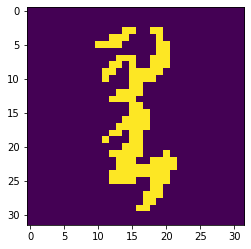

In [147]:
plt.imshow(f)

In [149]:
memo_comb = np.empty((max(N, M) + 1, max(N, M) + 1))
memo_factorial = np.empty(max(N, M) * 2 + 1)
memo_factorial[:] = np.nan
memo_comb[:] = np.nan

def my_comb(a, b):
    if np.isnan(memo_comb[a, b]):
        memo_comb[a, b] = comb(a, b, exact=True)
    return memo_comb[a, b]


def my_factorial(n):
    if np.isnan(memo_factorial[n]):
        memo_factorial[n] = factorial(n)
    return memo_factorial[n]

In [172]:
memo_K = np.empty((max(N, M) * 2 + 1, max(N, M) * 2 + 1))
memo_K[:] = np.nan

def K(n, x, p, N):
    if np.isnan(memo_K[n, x]):
        memo_K[n, x] = hyp2f1(-n, -x, -N, 1/p)
        if np.isnan(memo_K[n, x]):
            memo_K[n, x] = 0
    return memo_K[n, x]


# def K(n, x, p, N):
#     [c(n, i, N, p) for i in range(n)]
#     if np.isnan(memo_K[n, x]):
#         memo_K[n, x] = 0
#         np.multiply(memo_c[n, 0:n], np.array([x**i for i in range(n)]))
#     return memo_K[n, x]

In [173]:
memo_tilda_K = np.empty((N * 2 + 1, M * 2 + 1))
memo_c = np.empty((max(N, M) * 2 + 1, max(N, M) * 2 + 1))
memo_d = np.empty((max(N, M) * 2 + 1, max(N, M) * 2 + 1))
memo_d[:] = np.nan
memo_c[:] = np.nan
memo_tilda_K[:] = np.nan


def tilda_K(n, m, f, p):
    if np.isnan(memo_tilda_K[n, m]):
        N, M = f.shape
        memo_tilda_K[n, m] = 0
        for x in range(N):
            for y in range(M):
                memo_tilda_K[n, m] += f[x, y] * K(n, x, p, N) * K(m, y, p, M)
    return memo_tilda_K[n, m]


def c(n, i, N, p):
    if np.isnan(memo_c[n, i]):
        memo_c[n, i] = 0
        for k in range(i, n + 1):
            num = (-1 ** k) * my_factorial(n) * my_factorial(N - k)
            denom = (p ** k) * my_factorial(N) * my_factorial(k) * my_factorial(n - k)
            memo_c[n, i] += num / denom * stirling(k, i, kind=1)
    return memo_c[n, i]


def d(i, s, N, p):
    if np.isnan(memo_d[i, s]):
        memo_d[i, s] = 0
        for m in range(s, i + 1):
            num = (-1 ** s) * my_factorial(m) * my_factorial(N) * (p ** m)
            denom = my_factorial(m - s) * my_factorial(N - m) * my_factorial(m)
            memo_d[i, s] += stirling(i, m, kind=2) * num / (denom + 1e-100) # TODO
            

    return memo_d[i, s]

In [174]:
N, M = f.shape
p = 0.5

# TODO: filled memo_d and memo_tilda_K?
for i in tqdm(range(memo_d.shape[0])):
    for j in range(memo_d.shape[1]):
        d(i, j, N, p)

  0%|          | 0/65 [00:00<?, ?it/s]

In [175]:
for i in tqdm(range(memo_tilda_K.shape[0])):
    for j in range(memo_tilda_K.shape[1]):
        tilda_K(i, j, f, p)

  0%|          | 0/65 [00:00<?, ?it/s]

In [176]:
def Irs(n, m, f, p):
    
    N, M = f.shape
    
#     # TODO: filled memo_d and memo_tilda_K?
#     for i in range(memo_d.shape[0]):
#         for j in range(memo_d.shape[1]):
#             d(i, j, N, p)
#     for i in range(memo_tilda_K.shape[0]):
#         for j in range(memo_tilda_K.shape[1]):
#             tilda_K(i, j, f, p)

    u = 2 * get_central_moment(f, 2, 2) * get_central_moment(f, 0, 0) / (get_central_moment(f, 1, 1) ** 2)
    v = 2 * get_central_moment(f, 2, 2) * (get_central_moment(f, 1, 0) ** 2) / (get_central_moment(f, 0, 0) * (get_central_moment(f, 1, 1) ** 2))

    delta_f = tilda_K(0, 0, f, 0.5)
    theta_f = 0.5 * atan(
        (u * tilda_K(1, 1, f, 0.5) - u * tilda_K(0, 0, f, 0.5)) / 
        (tilda_K(2, 0, f, 0.5) - tilda_K(0, 2, f, 0.5))
    )
    cos_theta_f = cos(theta_f)
    sin_theta_f = sin(theta_f)
    Irs_nm = 0

    for i in range(n + 1):
        
        term4 = c(n, i, N, p)
        
        for j in range(m + 1):
            
            term5 = c(m, j, N, p)
            term8 = delta_f ** (- (i + j + 2) / 2)
            
            for s in range(i + 1):
                
                term2 = my_comb(i, s)
                
                for t in range(j + 1):
                    term1 = (-1) ** (j - t)
                    term3 = my_comb(j, t)
                    term9 = cos_theta_f ** (i + t - s)
                    term10 = sin_theta_f ** (j - t + s)

                    term7 = memo_d[s + t, 0:s + t + 1]
                    term6 = memo_d[i + j - s - t, 0:i + j - s - t + 1]

                    term7, term6 = np.meshgrid(term7, term6)
                    term11 = memo_tilda_K[0:i + j - s - t + 1, 0:s + t + 1]
                    
                    term6_7_11 = np.multiply(term6, term7)
                    term6_7_11 = np.multiply(term6_7_11, term11)
                    term6_7_11 = np.sum(term6_7_11)
                    
                    tmp = term1 * \
                        term2 * \
                        term3 * \
                        term4 * term5 * \
                        term8 * \
                        term9 * \
                        term10 * \
                        term6_7_11
                    Irs_nm += tmp

    return Irs_nm

In [177]:
tik = time.time()
Irs_nm = Irs(1, 16, f, p=0.5)
tok = time.time()
print(tok - tik, Irs_nm)

0.03798723220825195 22.958334402986583


In [178]:
Q = np.empty((N, M))
Q[:] = np.nan
    
# for i in tqdm(range(N)):
#     for j in range(M):
for i in tqdm(range(4)):
    for j in range(4):
        Q[i, j] = Irs(i, j, f, p=0.5)

  0%|          | 0/4 [00:00<?, ?it/s]

## (over) Vectorisation

In [105]:
def Irs(n, m, f, p):

    # =====================================

    N, M = f.shape


    for i in range(memo_c.shape[0]):
        for j in range(memo_c.shape[1]):
            c(i, j, N, p)
    for i in range(memo_d.shape[0]):
        for j in range(memo_d.shape[1]):
            d(i, j, N, p)
    for i in range(memo_tilda_K.shape[0]):
        for j in range(memo_tilda_K.shape[1]):
            tilda_K(i, j, f, p)
    for i in range(memo_comb.shape[0]):
        for j in range(memo_comb.shape[1]):
            my_comb(i, j)

    u = 2 * get_central_moment(f, 2, 2) * get_central_moment(f, 0, 0) / (get_central_moment(f, 1, 1) ** 2)
    v = 2 * get_central_moment(f, 2, 2) * (get_central_moment(f, 1, 0) ** 2) / (get_central_moment(f, 0, 0) * (get_central_moment(f, 1, 1) ** 2))

    delta_f = tilda_K(0, 0, f, 0.5)
    theta_f = 0.5 * atan(
        (u * tilda_K(1, 1, f, 0.5) - u * tilda_K(0, 0, f, 0.5)) / 
        (tilda_K(2, 0, f, 0.5) - tilda_K(0, 2, f, 0.5))
    )
    cos_theta_f = cos(theta_f)
    sin_theta_f = sin(theta_f)
    Irs_nm = 0


    # =====================================

    for i in range(n + 1):
        
        term4 = c(n, i, N, p)

        for j in range(m + 1):

            term5 = c(m, j, N, p)
            term8 = delta_f ** (- (i + j + 2) / 2)


            # =============================================
            s = np.array(range(0, i + 1))

            t = np.array(range(0, j + 1))
            t = np.expand_dims(t, axis=0).repeat(np.shape(s)[0], axis=0)
            s = np.expand_dims(s, axis=-1).repeat(t.shape[-1], axis=-1)


            a, b = np.meshgrid(s[:, 0], t[0, :])
            r = i + j - a - b + 1
            r = np.array([(r - x) for x in range(r.max(), 0, -1)]).T
            r = np.maximum(r, -1)
            s = np.expand_dims(s, axis=-1).repeat(r.shape[-1], axis=-1)
            t = np.expand_dims(t, axis=-1).repeat(r.shape[-1], axis=-1)

            a, b = np.meshgrid(s[:, 0, 0], t[0, :, 0])
            l = a + b + 1
            l = np.array([(l - x) for x in range(l.max(), 0, -1)]).T
            l = np.maximum(l, -1)
            l = np.expand_dims(l, axis=2).repeat(r.shape[2], axis=-2)
            s = np.expand_dims(s, axis=-1).repeat(l.shape[-1], axis=-1)
            t = np.expand_dims(t, axis=-1).repeat(l.shape[-1], axis=-1)
            r = np.expand_dims(r, axis=-1).repeat(l.shape[-1], axis=-1)        
            # =============================================

            term1 = np.power(-1, j - t)
            term2 = memo_comb[i, s]
            term3 = memo_comb[j, t]
            term6 = memo_d[i + j - s - t, r]
            term7 = memo_d[s + t, l]
            term9 = np.power(cos_theta_f, i + t - s)
            term10 = np.power(sin_theta_f, j - t + s)
            term11 = memo_tilda_K[r, l]
            

            tmp = [term1, term2, term3, term6, term7, term9, term10, term11]
            tmp += [s!=-1, t!=-1, r!=-1, l!=-1]
            tmp = np.prod(np.array(tmp), axis=0)
            tmp = tmp.sum()
            Irs_nm += tmp * term4 * term5 * term8
            
    return Irs_nm

In [106]:
tik = time.time()
Irs_nm = Irs(1, 16, f, p=0.5)
tok = time.time()
print(tok - tik, Irs_nm)

/var/folders/g4/bkdm_ks93mb92cqpsfgpyldr0000gn/T/ipykernel_5158/2765092938.py:10: RuntimeWarning: invalid value encountered in double_scalars
  memo_c[n, i] += num / denom * stirling(k, i, kind=1)


3.9376220703125 10.899358860993468


In [1055]:
# sanity check

# check t
for s_idx in range(i + 1):
    assert(t[s_idx, 0, 0, 0] in [0, -1])
    assert(t[s_idx, -1, 0, 0] == j)
    
# check r
for s_idx in range(i + 1):
    for t_idx in range(j + 1):
        assert(r[s_idx, t_idx, 0, 0] in [0, -1])
        assert(r[s_idx, t_idx, -1, 0] == i + j - s_idx - t_idx)
        
# check l
for s_idx in range(i + 1):
    for t_idx in range(j + 1):
        for r_idx in range(i + j - s_idx - t_idx + 1):
            assert(l[s_idx, t_idx, r_idx, 0] in [0, -1])
            assert(l[s_idx, t_idx, r_idx, -1] == s_idx + t_idx)